## **Import Python Modules**

In [1]:
#%pip install tensorflow
#%pip install xgboost

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

ModuleNotFoundError: No module named 'tensorflow.keras.models'

## **Upload File**

In [44]:
df = pd.read_csv("SalesData.csv")

# Explore the dataset
print(df.head())


                         Region Country   Item Type Sales Channel  \
0  Middle East and North Africa   Libya   Cosmetics       Offline   
1                 North America  Canada  Vegetables        Online   
2  Middle East and North Africa   Libya   Baby Food       Offline   
3                          Asia   Japan      Cereal       Offline   
4            Sub-Saharan Africa    Chad      Fruits       Offline   

  Order Priority  Order Date   Order ID   Ship Date  Units Sold  Unit Price  \
0              M  10/18/2014  686800706  10/31/2014        8446      437.20   
1              M   11/7/2011  185941302   12/8/2011        3018      154.06   
2              C  10/31/2016  246222341   12/9/2016        1517      255.28   
3              C   4/10/2010  161442649   5/12/2010        3322      205.70   
4              H   8/16/2011  645713555   8/31/2011        9845        9.33   

   Unit Cost  Total Revenue  Total Cost  Total Profit  
0     263.33     3692591.20  2224085.18    1468506.02 

# Data Preprocessing

In [24]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          1000 non-null   object 
 1   Country         1000 non-null   object 
 2   Item Type       1000 non-null   object 
 3   Sales Channel   1000 non-null   object 
 4   Order Priority  1000 non-null   object 
 5   Order Date      1000 non-null   object 
 6   Order ID        1000 non-null   int64  
 7   Ship Date       1000 non-null   object 
 8   Units Sold      1000 non-null   int64  
 9   Unit Price      1000 non-null   float64
 10  Unit Cost       1000 non-null   float64
 11  Total Revenue   1000 non-null   float64
 12  Total Cost      1000 non-null   float64
 13  Total Profit    1000 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 109.5+ KB
None


In [25]:
df = df.drop(["Unit Cost",  "Total Revenue",  "Total Cost",  "Total Profit"], axis =1)

In [26]:


# Convert "Order Date" and "Ship Date" to datetime objects
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Optionally, I can calculate the time duration between order and ship dates
df['Order_Ship_Duration'] = (df['Ship Date'] - df['Order Date']).dt.days

# Display the modified DataFrame
print(df.head())


                         Region Country   Item Type Sales Channel  \
0  Middle East and North Africa   Libya   Cosmetics       Offline   
1                 North America  Canada  Vegetables        Online   
2  Middle East and North Africa   Libya   Baby Food       Offline   
3                          Asia   Japan      Cereal       Offline   
4            Sub-Saharan Africa    Chad      Fruits       Offline   

  Order Priority Order Date   Order ID  Ship Date  Units Sold  Unit Price  \
0              M 2014-10-18  686800706 2014-10-31        8446      437.20   
1              M 2011-11-07  185941302 2011-12-08        3018      154.06   
2              C 2016-10-31  246222341 2016-12-09        1517      255.28   
3              C 2010-04-10  161442649 2010-05-12        3322      205.70   
4              H 2011-08-16  645713555 2011-08-31        9845        9.33   

   Order_Ship_Duration  
0                   13  
1                   31  
2                   39  
3                   32

In [27]:

# Assuming I have a DataFrame df with the columns mentioned

# Get columns with fewer than 20 unique elements
get_dummies_cols = [col for col in df.columns if df[col].nunique() < 20 and df[col].dtype == 'O']

# Get columns with 20 or more unique elements
label_encoder_cols = [col for col in df.columns if df[col].nunique() >= 20 and df[col].dtype == 'O']

# Apply get_dummies for columns with fewer than 20 unique elements
df_dummies = pd.get_dummies(df[get_dummies_cols], drop_first=True)

# Apply LabelEncoder for columns with 20 or more unique elements
label_encoder = LabelEncoder()
for col in label_encoder_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Concatenate the modified columns back to the original DataFrame
df = pd.concat([df.drop(columns=get_dummies_cols), df_dummies], axis=1)

# Display the modified DataFrame
print(df.head())


   Country Order Date   Order ID  Ship Date  Units Sold  Unit Price  \
0       89 2014-10-18  686800706 2014-10-31        8446      437.20   
1       26 2011-11-07  185941302 2011-12-08        3018      154.06   
2       89 2016-10-31  246222341 2016-12-09        1517      255.28   
3       76 2010-04-10  161442649 2010-05-12        3322      205.70   
4       29 2011-08-16  645713555 2011-08-31        9845        9.33   

   Order_Ship_Duration  Region_Australia and Oceania  \
0                   13                             0   
1                   31                             0   
2                   39                             0   
3                   32                             0   
4                   15                             0   

   Region_Central America and the Caribbean  Region_Europe  ...  \
0                                         0              0  ...   
1                                         0              0  ...   
2                                  

# PCA

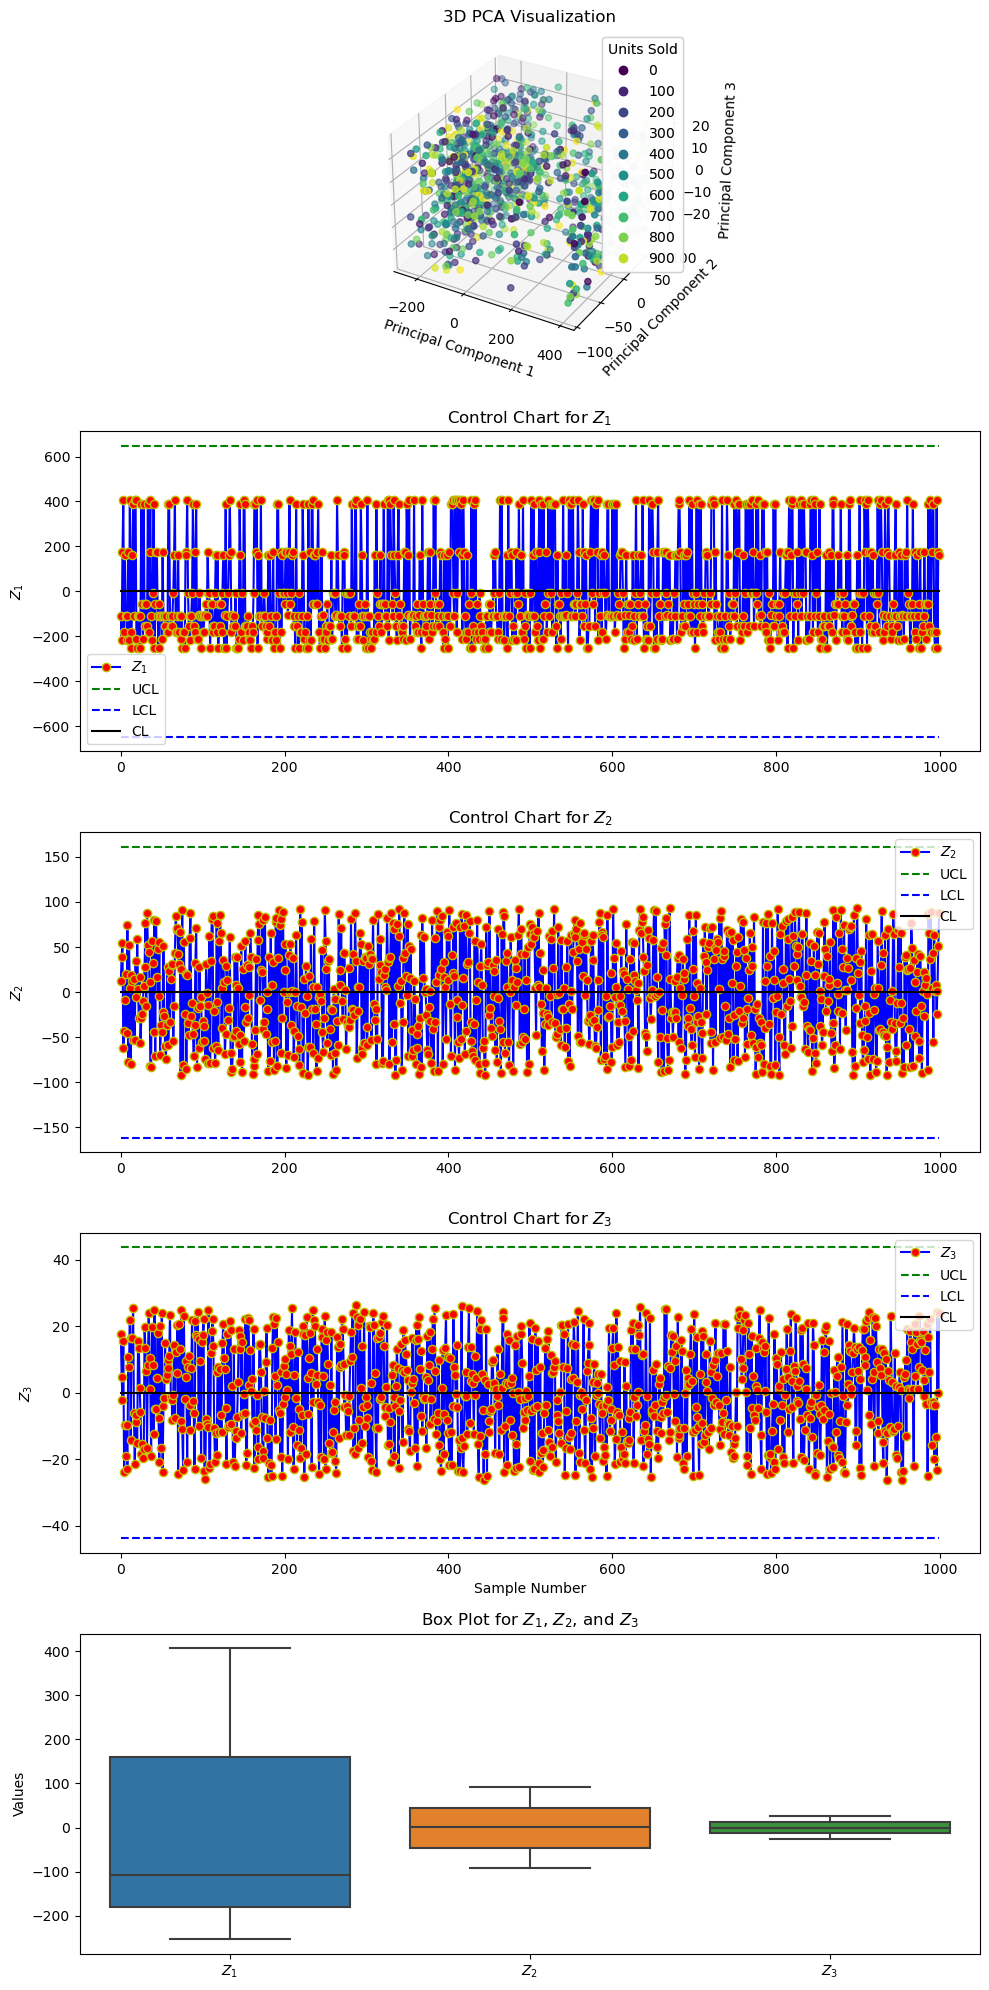

In [28]:
# Assuming df is my DataFrame
df = df.sort_values(by="Order Date", ascending=True).reset_index(drop=True)

# Drop unnecessary columns
df2 = df.drop(["Order Date", "Order ID", "Ship Date"], axis=1)

# Use PCA for dimensionality reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(df2.drop("Units Sold", axis=1))


# Extract Z1, Z2, and Z3
Z1 = X_pca[:, 0]
Z2 = X_pca[:, 1]
Z3 = X_pca[:, 2]

# Lambda values (adjust as needed)
Lambda = pca.explained_variance_

# Create subplots
fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(511, projection="3d")  # 3D subplot
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

# PCA 3D Visualization
scatter = ax1.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=np.arange(len(df2)),  # Use some color for each point
    cmap="viridis",
    marker="o",
)
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_zlabel("Principal Component 3")  # Use set_zlabel directly on Axes3D
ax1.set_title("3D PCA Visualization")
legend1 = ax1.legend(*scatter.legend_elements(), title="Units Sold")
ax1.add_artist(legend1)

# Z1 Control Chart
ax2.plot(Z1, "-b", marker="o", mec="y", mfc="r", label="$Z_1$")
ax2.plot([3 * np.sqrt(Lambda[0]) for _ in range(len(Z1))], "--g", label="UCL")
ax2.plot([-3 * np.sqrt(Lambda[0]) for _ in range(len(Z1))], "--b", label="LCL")
ax2.plot([0 for _ in range(len(Z1))], "-", color="black", label="CL")
ax2.set_ylabel("$Z_1$")
ax2.set_title("Control Chart for $Z_1$")
ax2.legend()

# Z2 Control Chart
ax3.plot(Z2, "-b", marker="o", mec="y", mfc="r", label="$Z_2$")
ax3.plot([3 * np.sqrt(Lambda[1]) for _ in range(len(Z2))], "--g", label="UCL")
ax3.plot([-3 * np.sqrt(Lambda[1]) for _ in range(len(Z2))], "--b", label="LCL")
ax3.plot([0 for _ in range(len(Z2))], "-", color="black", label="CL")
ax3.set_ylabel("$Z_2$")
ax3.set_title("Control Chart for $Z_2$")
ax3.legend()

# Z3 Control Chart
ax4.plot(Z3, "-b", marker="o", mec="y", mfc="r", label="$Z_3$")
ax4.plot([3 * np.sqrt(Lambda[2]) for _ in range(len(Z3))], "--g", label="UCL")
ax4.plot([-3 * np.sqrt(Lambda[2]) for _ in range(len(Z3))], "--b", label="LCL")
ax4.plot([0 for _ in range(len(Z3))], "-", color="black", label="CL")
ax4.set_xlabel("Sample Number")
ax4.set_ylabel("$Z_3$")
ax4.set_title("Control Chart for $Z_3$")
ax4.legend()

# Box Plot
sns.boxplot(data=[Z1, Z2, Z3], ax=ax5)
ax5.set_xticklabels(["$Z_1$", "$Z_2$", "$Z_3$"])
ax5.set_ylabel("Values")
ax5.set_title("Box Plot for $Z_1$, $Z_2$, and $Z_3$")

plt.tight_layout()
plt.show()

In [29]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(
    data=X_pca[:, 0:5],
    columns=[
        "Principal Component 1",
        "Principal Component 2",
        "Principal Component 3",
        "Principal Component 4",
        "Principal Component 5",
    ],
)

# Add "Units Sold" column to this DataFrame
df_pca["Units Sold"] = df2["Units Sold"].values

# Add Order Date column for visualization purposes
df_pca["Order Date"] = df["Order Date"]

# Splitting the data into 70% training set and 30% test set
# train_extended, test_extended = train_test_split(df_pca, test_size=0.2, random_state=23)

# Split consecutively the dataset
train_extended = df_pca.iloc[0:800]
test_extended = df_pca.iloc[800:]

# Remove the Order date (we'll use it later)
train = train_extended.drop("Order Date", axis=1)
test = test_extended.drop("Order Date", axis=1)

# Creating input features X and target variable y for both training set and test set
X_train = train.drop("Units Sold", axis=1)
y_train = train["Units Sold"]
X_test = test.drop("Units Sold", axis=1)
y_test = test["Units Sold"]

# Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
rf_predictions = rf_model.predict(X_test)

# Compute MSE
rf_mse = mean_squared_error(y_test, rf_predictions)

print(f"Random Forest MSE: {rf_mse}")

Random Forest MSE: 8921568.0539725


# Visualizatons

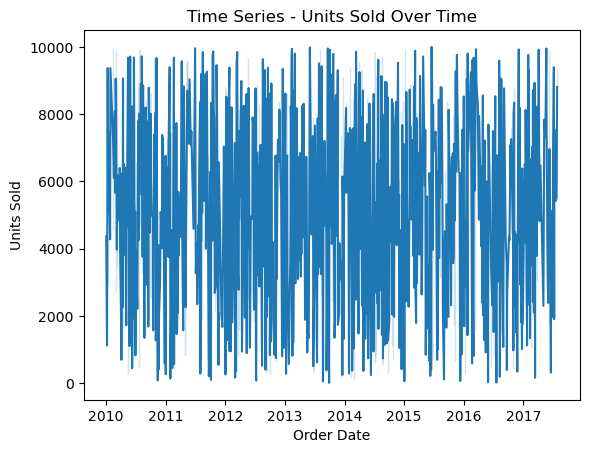

In [30]:
sns.lineplot(x='Order Date', y='Units Sold', data=df)
plt.title('Time Series - Units Sold Over Time')
plt.show()

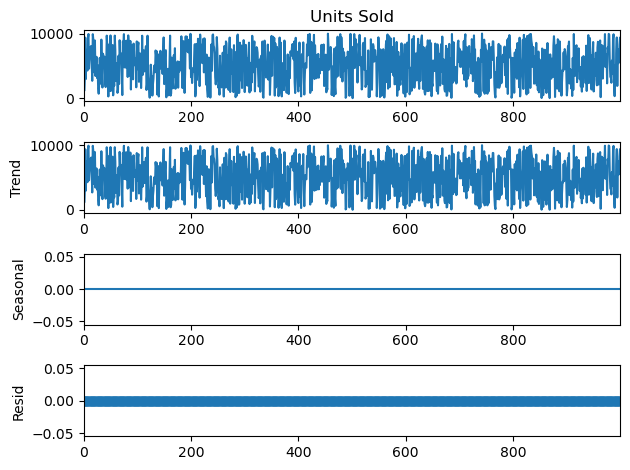

In [31]:

result = seasonal_decompose(df['Units Sold'], model='additive', period=1)
result.plot()
plt.show()

/var/folders/6g/c1kh9krx733fdnj0qwrkgh9w0000gn/T/ipykernel_14197/2013203906.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


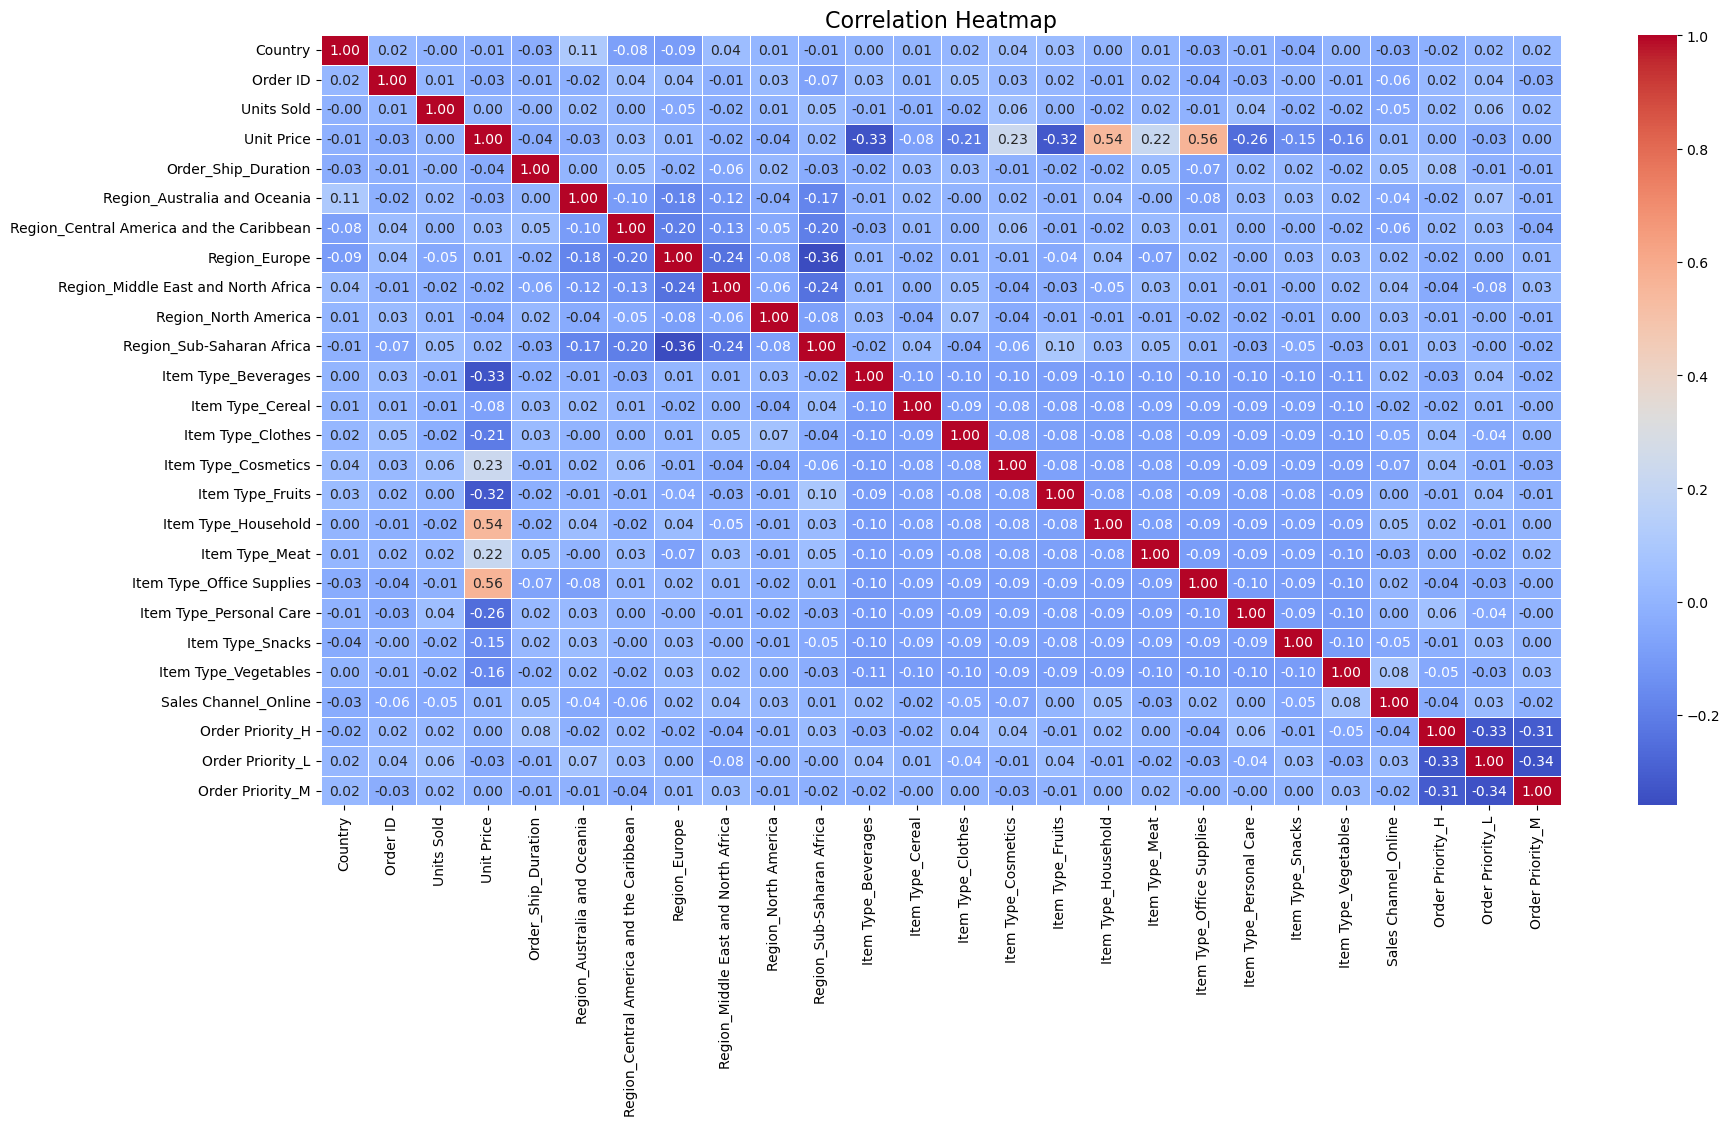

In [32]:
# Calculate the correlation matrix
corr_matrix = df.corr()
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))
# Create a heatmap with annotations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
# Set the title
plt.title('Correlation Heatmap', fontsize=16)
# Show the plot
plt.show()


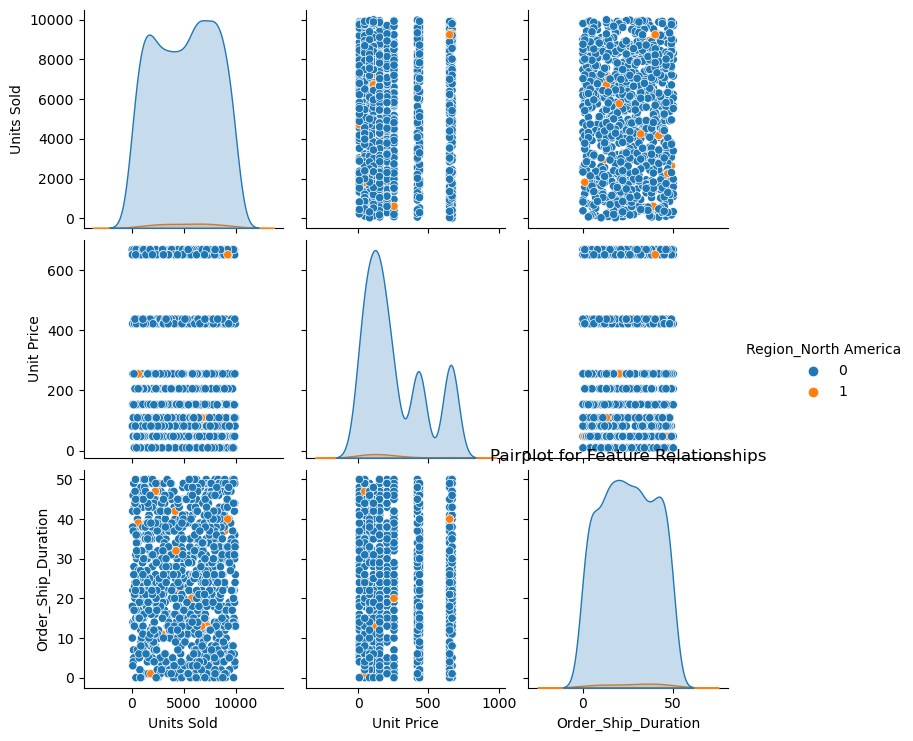

In [33]:
sns.pairplot(df[['Units Sold', 'Unit Price', 'Order_Ship_Duration', 'Region_North America']], hue='Region_North America')
plt.title('Pairplot for Feature Relationships')
plt.show()

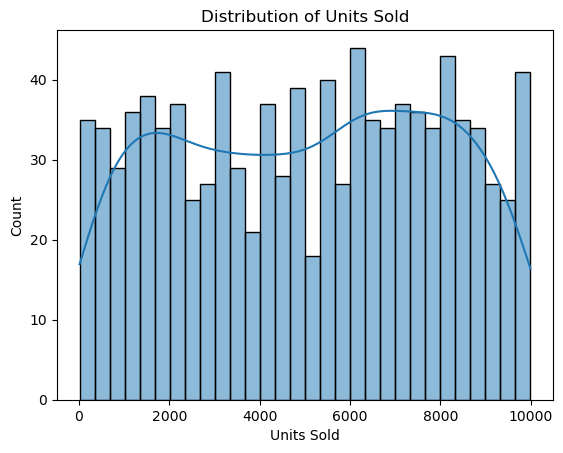

In [34]:
sns.histplot(df['Units Sold'], bins=30, kde=True)
plt.title('Distribution of Units Sold')
plt.show()

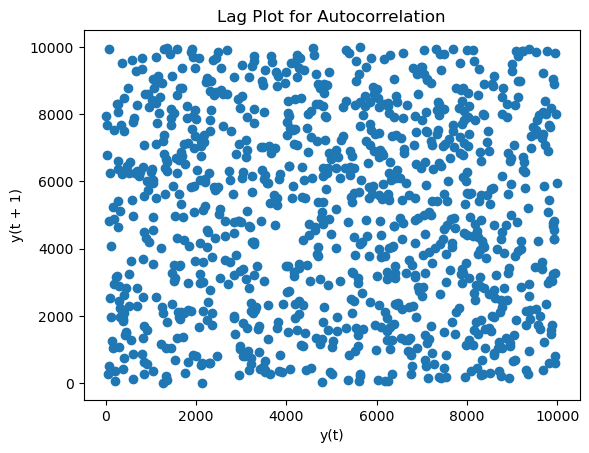

In [35]:
from pandas.plotting import lag_plot
lag_plot(df['Units Sold'])
plt.title('Lag Plot for Autocorrelation')
plt.show()


# predictions

In [36]:
# Handle missing values
df.dropna(inplace=True)

# Assuming df is your DataFrame

# Calculate the index for splitting
split_index = int(0.8 * len(df))

# Split the data into training and testing sets
train_data = df.iloc[:split_index, :]
test_data = df.iloc[split_index:, :]

X_train = train_data.drop(["Order Date","Order ID", "Ship Date", "Units Sold"], axis =1)
X_test = test_data.drop(["Order Date","Order ID", "Ship Date", "Units Sold"], axis =1)
y_train = train_data["Units Sold"]
y_test = test_data["Units Sold"]

# Display the shapes of the resulting sets

print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)
print("Train y shape:", y_train.shape)
print("Test y shape:", y_test.shape)


Train X shape: (800, 24)
Test X shape: (200, 24)
Train y shape: (800,)
Test y shape: (200,)


# RANDOM FOREST MODEL

In [37]:
# Use a machine learning model for forecasting (example with RandomForestRegressor)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 8960617.269762501


# KNN MODEL

In [38]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Use a machine learning model for forecasting (example with KNeighborsRegressor)
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

# Make predictions
knn_predictions = knn_model.predict(X_test)

# Evaluate the model
knn_mse = mean_squared_error(y_test, knn_predictions)
print(f"KNN Mean Squared Error: {knn_mse}")

KNN Mean Squared Error: 9654135.873


# RNN MODEL

In [39]:
# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM input (assuming X_train and X_test are 2D arrays)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))))
model.add(Dense(1))  # Output layer with 1 neuron for regression
model.compile(optimizer='adam', loss='mse')  # Use mean squared error for regression

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test_reshaped).flatten()

# Evaluate the model
lstm_mse = mean_squared_error(y_test, lstm_predictions)
print(f"BiLSTM Mean Squared Error: {lstm_mse}")


NameError: name 'Sequential' is not defined

# XGBOOST MODEL

In [ ]:
# Define hyperparameters
from xgboost import XGBRegressor
params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 1000,
    'seed': 27
}

# Instantiate an XGBoost regressor object with the specified hyperparameters
xgb_model = XGBRegressor(**params)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print(f"XGBoost Mean Squared Error: {xgb_mse}")

# DECISION TREE MODEL

In [ ]:
# Define hyperparameters
params_d = {
    'max_depth': 6,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 27
}

# Instantiate a decision tree regressor object with the specified hyperparameters
dt_model = DecisionTreeRegressor(**params_d)

# Train the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
dt_predictions = dt_model.predict(X_test)

# Evaluate the model
dt_mse = mean_squared_error(y_test, dt_predictions)
print(f"Decision Tree Mean Squared Error: {dt_mse}")


# Tuned Random Forest Model

In [ ]:


# Define the RandomForestRegressor
model = RandomForestRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)

# Make predictions
predictions = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error with Tuned Model: {mse}")


### Visualization Comparison

In [40]:
df_xgb_vis = pd.DataFrame({})
df_xgb_vis["Order Date"] = test_extended["Order Date"]
df_xgb_vis["Units Sold"] = y_test


for y, label in zip(
    [
        knn_predictions,
        xgb_predictions,
        dt_predictions,
        predictions,
    ],
    [
        "KNN",
        "XGBoost",
        "Decision Tree",
        "RandomForest",
    ],
):
    plt.figure(figsize=(14, 6))
    sns.lineplot(
        x=df_xgb_vis["Order Date"], y=df_xgb_vis["Units Sold"], label="Units Sold"
    )
    sns.lineplot(x=df_xgb_vis["Order Date"], y=y, label=label)
    plt.legend()
    plt.title(f"{label} Forecast")
    plt.show()

NameError: name 'xgb_predictions' is not defined

In [41]:
df_xgb_vis = pd.DataFrame({})
df_xgb_vis["Order Date"] = test_extended["Order Date"]
df_xgb_vis["Units Sold"] = y_test

# Add predictions to the DataFrame
df_xgb_vis["KNN"] = knn_predictions
df_xgb_vis["XGBoost"] = xgb_predictions
df_xgb_vis["Decision Tree"] = dt_predictions
df_xgb_vis["RandomForest"] = predictions

# Simplify the DataFrame for easier plotting
df_melted = pd.melt(df_xgb_vis, id_vars=["Order Date", "Units Sold"], var_name="Model", value_name="Predictions")

# Plot the data
plt.figure(figsize=(14, 6))
sns.lineplot(x="Order Date", y="Units Sold", data=df_melted, label="Units Sold", color='black')
sns.lineplot(x="Order Date", y="Predictions", hue="Model", data=df_melted)
plt.legend()
plt.title("Forecast Comparison")
plt.show()

NameError: name 'xgb_predictions' is not defined